## Fitting the SFR-M$_*$ correlation at z~0.6

A correlation between the rate at which galaxies form stars (SFR) and their stellar mass ($M_*$) has been observed across a wide range of stellar masses and redshifts (see [`Salmon+15`](https://arxiv.org/pdf/1407.6012), [`Kurczynski+17`](https://arxiv.org/pdf/1602.03909)). This is visualized in the graphic below by Camilla Pacifici.

<img src='ms2.png' width=600px alt='SFR-Mstar-correlation'>

Determining the slope and normalization of this relation can be challenging, since the population of star forming galaxies can be difficult to distinguish from the populations of quiescent galaxies below it and the population of 'starburst' galaxies above it. 

In this notebook we will play around with a sample of galaxies for which the SFR and M$_*$ have been estimated through a technique called Spectral Energy Distribution (SED) fitting and consider the issues involved in fitting it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

from scipy.optimize import curve_fit
from sklearn import linear_model

import scipy.odr

# importing and visualizaing the data

the `np.loadtxt` function works well for simple text files that contain numerical data.
for more complicated heterogeneous data, consider using the `np.genfromtxt` function.

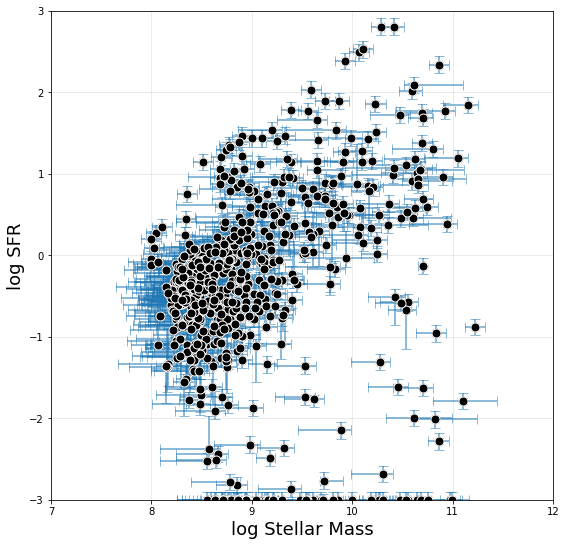

In [2]:
[log_mstar, log_mstar_err_up, log_mstar_err_dn, 
 log_sfr, log_sfr_err_up, log_sfr_err_dn] = np.loadtxt('../../data/sfr_mstar_sample.txt')

# symmetrize the errors for now
sfr_err = np.mean(np.array([log_sfr_err_up, log_sfr_err_dn]),axis=0)
mass_err = np.mean(np.array([log_mstar_err_up, log_mstar_err_dn]),axis=0)

plt.figure(figsize=(9,9))
plt.errorbar(log_mstar,log_sfr,xerr=(log_mstar_err_up, log_mstar_err_dn), yerr = (log_sfr_err_up,log_sfr_err_dn),
             marker='o',markersize=9,lw=0,elinewidth=2,alpha=0.5,markeredgecolor='k',capsize=5)
plt.errorbar(log_mstar,log_sfr,marker='o',markersize=9,markeredgecolor='w',lw=0,color='k')
plt.axis([7,12,-3,3])
plt.xlabel('log Stellar Mass',fontsize=18)
plt.ylabel('log SFR',fontsize=18)
plt.grid(alpha=0.3)
plt.show()



### Selecting Star Forming galaxies

There are a few ways of selecting the subsample of galaxies in this dataset that are actively forming stars. Some of these include using additional data, such as a color-magnitude diagram, to implement the selection. Another method, that we'll be using here, involves a selection using a quantity called the Specific Star Formation Rate, where

$$sSFR = SFR / M_* $$ 

To see how cuts in sSFR look, let's first plot a histogram for this data.

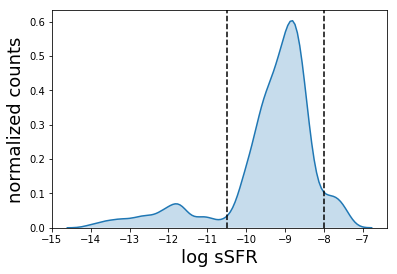

In [3]:
ssfr = np.log10(10**log_sfr / 10**log_mstar)

sns.kdeplot(ssfr,shade=True)
plt.plot([-10.5,-10.5],[0,0.65],'k--')
plt.plot([-8,-8],[0,0.65],'k--')

plt.xlabel('log sSFR',fontsize=18)
plt.ylabel('normalized counts',fontsize=18)
plt.show()

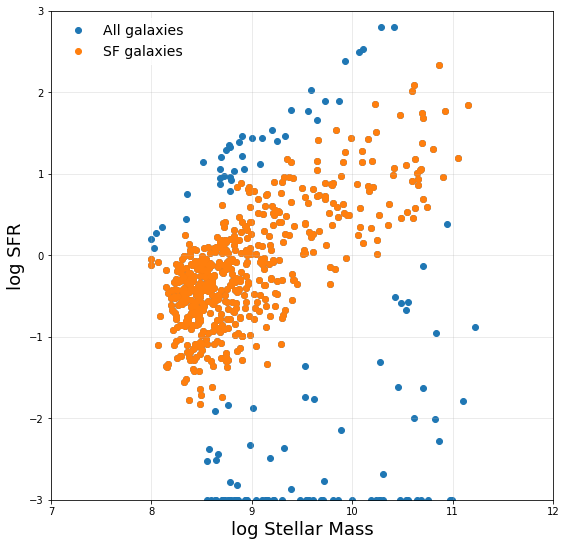

In [4]:
# let's select this sample, and see how it looks.

SFG_mask = (ssfr < -8) & (ssfr > -10.5)

plt.figure(figsize=(9,9))
plt.scatter(log_mstar, log_sfr, label= 'All galaxies')
plt.scatter(log_mstar[SFG_mask], log_sfr[SFG_mask], label = 'SF galaxies')
plt.axis([7,12,-3,3])
plt.xlabel('log Stellar Mass',fontsize=18)
plt.ylabel('log SFR',fontsize=18)
plt.legend(fontsize=14, edgecolor='w',loc=2)
plt.grid(alpha=0.3)
plt.show()




# Fitting the data:

We'll go through a variety of scenarios in fitting the data, 

- Case 1: Assuming no errors and no outliers, using `scipy.optimize.curve_fit` without centering the data
- Case 2: Effects of centering the data
- Case 3: Outlier rejection: Comparing many different linear regressors in `sklearn.linear_model` to be robust to outliers
- Case 4: Accounting for measurement uncertainties in the fitting.
- Case 5: Yet another method: Orthogonal Distance Regression

In parallel to this, it is extremely instructive to read the following paper on fitting a model to data: [Hogg, Bovy and Lang, 2010](https://arxiv.org/abs/1008.4686). Work through the exercises in the paper, and if you're interested, try applying the methods to fitting the data in this notebook.

R^2 of fit = 0.481


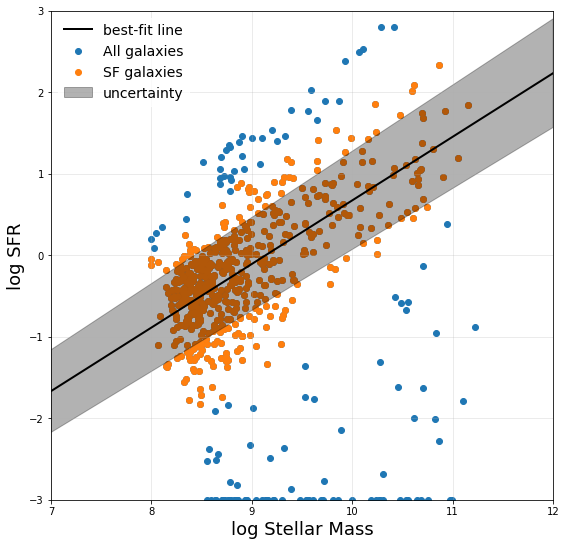

In [5]:
#---------------------------------------------------------------
# Case 1. The simple fit
#---------------------------------------------------------------

# define a function to return SFR values corresponding to input Stellar Mass values following a linear correlation

def line_model(mass, slope, intercept):
    return mass*slope + intercept

# fit the model to the data to estimate the slope and intercept
# popt - optimal parameters
# pcov - parameter covariances
 
popt, pcov = curve_fit(line_model, log_mstar[SFG_mask], log_sfr[SFG_mask])

# Now calculate how well the fit does. 
# Here, we use the coefficient of determination, or R^2, which quantifies
#     the amount of variance unexplained by the model. 
total_var = np.sum((log_sfr[SFG_mask] - np.mean(log_sfr[SFG_mask]))**2)
explained_var = np.sum((line_model(log_mstar[SFG_mask], *popt) - np.mean(log_sfr[SFG_mask]))**2)
Rsq_fit = 1-explained_var/total_var
print('R^2 of fit = %.3f' %Rsq_fit)

#----------------------------------------------------------------------------------------------------------------------
# Plot your results

mass_arr = np.arange(6,12.1)

plt.figure(figsize=(9,9))
plt.scatter(log_mstar, log_sfr, label= 'All galaxies')
plt.scatter(log_mstar[SFG_mask], log_sfr[SFG_mask], label = 'SF galaxies')
plt.plot(mass_arr,line_model(mass_arr,*popt),'k',lw=2,label='best-fit line')
plt.fill_between(mass_arr, 
                 line_model(mass_arr,popt[0]+np.sqrt(pcov[0,0]),popt[1]+np.sqrt(pcov[1,1])),
                 line_model(mass_arr,popt[0]-np.sqrt(pcov[0,0]),popt[1]-np.sqrt(pcov[1,1])),
                 alpha=0.3,color='k',label='uncertainty')
plt.axis([7,12,-3,3])
plt.xlabel('log Stellar Mass',fontsize=18)
plt.ylabel('log SFR',fontsize=18)
plt.legend(fontsize=14, edgecolor='w',loc=2)
plt.grid(alpha=0.3)
plt.show()


Sample center in log stellar mass: 8.715
R^2 of fit = 0.481


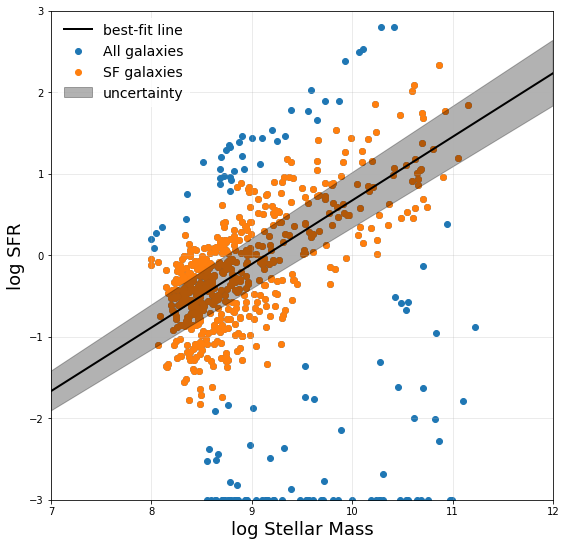

In [6]:
#---------------------------------------------------------------
# Case 2. Centering the data: 
#---------------------------------------------------------------
# Does the fit change?
# Notice how the uncertainties have now decreased. 
#     Why do you think this happens?

def line_model(mass, slope, intercept):
    return mass*slope + intercept

# we approximately center the data using the median of the observed distribution:

sample_center = np.median(log_mstar[SFG_mask])
print('Sample center in log stellar mass: %.3f' %sample_center)
# For the remaining exercises we approximate this to ~ 9

popt, pcov = curve_fit(line_model, log_mstar[SFG_mask]-sample_center, log_sfr[SFG_mask])
popt[0] = popt[0]
popt[1] = popt[1] - sample_center*popt[0]


# Now calculate how well the fit does. 
# Here, we use the coefficient of determination, or R^2, which quantifies
#     the amount of variance unexplained by the model. 
total_var = np.sum((log_sfr[SFG_mask] - np.mean(log_sfr[SFG_mask]))**2)
explained_var = np.sum((line_model(log_mstar[SFG_mask], *popt) - np.mean(log_sfr[SFG_mask]))**2)
Rsq_fit = 1-explained_var/total_var
print('R^2 of fit = %.3f' %Rsq_fit)

#----------------------------------------------------------------------------------------------------------------------
# Plot your results

mass_arr = np.arange(6,12.1)
plt.figure(figsize=(9,9))
plt.scatter(log_mstar, log_sfr, label= 'All galaxies')
plt.scatter(log_mstar[SFG_mask], log_sfr[SFG_mask], label = 'SF galaxies')
plt.plot(mass_arr,line_model(mass_arr,*popt),'k',lw=2,label='best-fit line')
plt.fill_between(mass_arr, 
                 line_model(mass_arr,popt[0]+np.sqrt(pcov[0,0]),popt[1]+np.sqrt(pcov[1,1])),
                 line_model(mass_arr,popt[0]-np.sqrt(pcov[0,0]),popt[1]-np.sqrt(pcov[1,1])),
                 alpha=0.3,color='k',label='uncertainty')
plt.axis([7,12,-3,3])
plt.xlabel('log Stellar Mass',fontsize=18)
plt.ylabel('log SFR',fontsize=18)
plt.legend(fontsize=14, edgecolor='w',loc=2)
plt.grid(alpha=0.3)
plt.show()


We briefly consider the topic of how to handle outliers in analysis. 
Every fitting method will be affected by outliers, but some are affected to a greater extent than others. 
In addition to the Ordinary Least-Squares (OLS) used earlier, we consider three different 'robust' estimators:
    
- [RANSAC](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html#sklearn.linear_model.RANSACRegressor) (RANdom SAmple Consensus) - starts from a randomly generated subset of inliers to iteratively estimate the correlation.
- [Theil-Sen](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TheilSenRegressor.html#sklearn.linear_model.TheilSenRegressor) -  calculates least square solutions on subsets with size n_subsamples of the samples in X
- [Huber](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor) - A robust hybrid of lasso and ridge regression, optimises a loss function.        

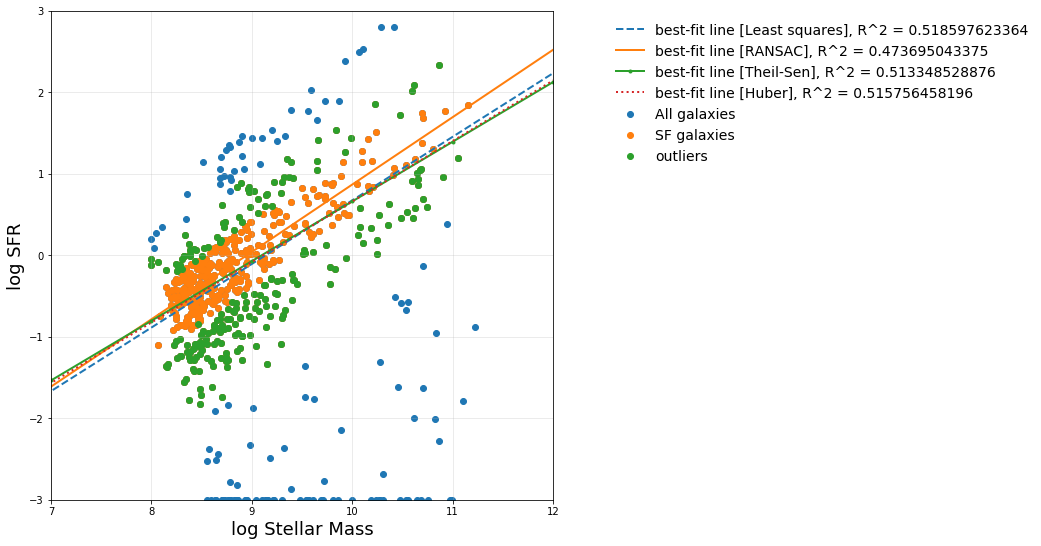

In [7]:
#---------------------------------------------------------------
# Case 3. Dealing with outliers #1 - using the SFG selected sample
#---------------------------------------------------------------
# consider how the different methods do. 
# is any one of them obviously better than the others? 

x = log_mstar[SFG_mask].reshape(-1,1)-9
y = log_sfr[SFG_mask].reshape(-1,1)

mass_arr = np.arange(6,12.1).reshape(-1,1)

#-------------------------------------------------------------------------
# Linear model

lr = linear_model.LinearRegression()
lr.fit(x, y)
line_y = lr.predict(mass_arr-9)

#-------------------------------------------------------------------------
# RANSAC - this also returns a list of objects that it classifies as outliers

ransac = linear_model.RANSACRegressor(random_state=12)
ransac.fit(x, y)
line_y_ransac = ransac.predict(mass_arr-9)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

#-------------------------------------------------------------------------
# Theil-Sen estimator

ts = linear_model.TheilSenRegressor(random_state=12)
ts.fit(x, y)
line_y_ts = ts.predict(mass_arr-9)

#-------------------------------------------------------------------------
# Huber estimator

huber = linear_model.HuberRegressor()
huber.fit(x, y)
line_y_huber = huber.predict(mass_arr-9)


#----------------------------------------------------------------------------------------------------------------------
# Plot your results

plt.figure(figsize=(9,9))
plt.scatter(log_mstar, log_sfr, label= 'All galaxies')
plt.scatter(log_mstar[SFG_mask], log_sfr[SFG_mask], label = 'SF galaxies')
plt.scatter(x[outlier_mask]+9,y[outlier_mask],s=36,label='outliers')
plt.plot(mass_arr,line_y,'--',lw=2,label='best-fit line [Least squares], R^2 = '+str(lr.score(x,y)))
plt.plot(mass_arr,line_y_ransac,'-',lw=2,label='best-fit line [RANSAC], R^2 = '+str(ransac.score(x,y)))
plt.plot(mass_arr,line_y_ts,'.-',lw=2,label='best-fit line [Theil-Sen], R^2 = '+str(ts.score(x,y)))
plt.plot(mass_arr,line_y_huber,':',lw=2,label='best-fit line [Huber], R^2 = '+str(huber.score(x,y)))

plt.axis([7,12,-3,3])
plt.xlabel('log Stellar Mass',fontsize=18)
plt.ylabel('log SFR',fontsize=18)
plt.legend(fontsize=14, edgecolor='w',loc=2,bbox_to_anchor=(1.1,1))
plt.grid(alpha=0.3)
plt.show()


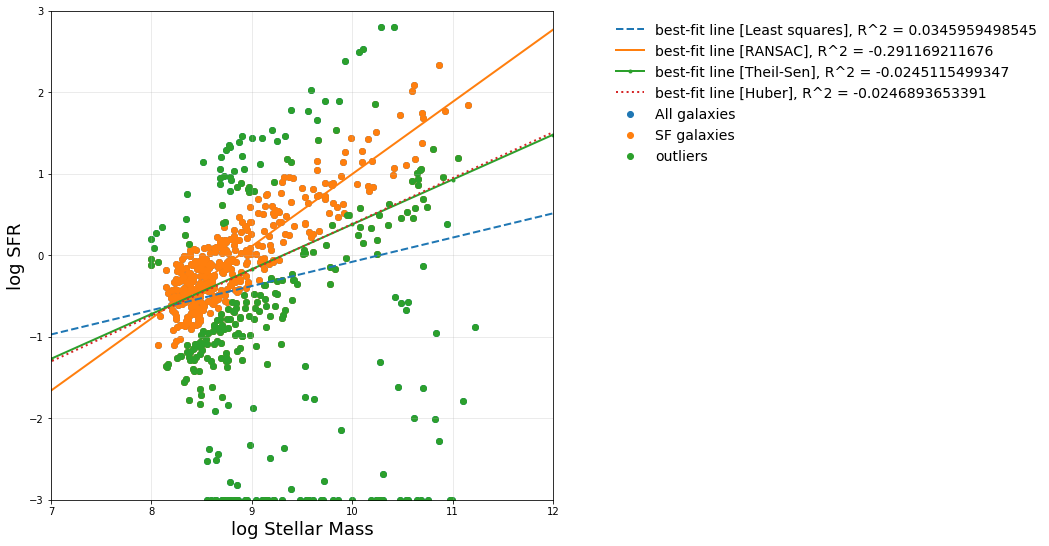

In [8]:
#---------------------------------------------------------------
# Case 3. Dealing with outliers #2 - using the full sample
#---------------------------------------------------------------
# now consider how the different methods do. 
# is any one of them obviously better than the others? 

x = log_mstar.reshape(-1,1)-9
y = log_sfr.reshape(-1,1)


mass_arr = np.arange(6,12.1).reshape(-1,1)

#-------------------------------------------------------------------------
# Linear model

lr = linear_model.LinearRegression()
lr.fit(x, y)
line_y = lr.predict(mass_arr-9)

#-------------------------------------------------------------------------
# RANSAC - this also returns a list of objects that it classifies as outliers

ransac = linear_model.RANSACRegressor(random_state=42)
ransac.fit(x, y)
line_y_ransac = ransac.predict(mass_arr-9)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

#-------------------------------------------------------------------------
# Theil-Sen estimator

ts = linear_model.TheilSenRegressor(random_state=12)
ts.fit(x, y)
line_y_ts = ts.predict(mass_arr-9)

#-------------------------------------------------------------------------
# Huber estimator

huber = linear_model.HuberRegressor()
huber.fit(x, y)
line_y_huber = huber.predict(mass_arr-9)


#----------------------------------------------------------------------------------------------------------------------
# Plot your results

plt.figure(figsize=(9,9))
plt.scatter(log_mstar, log_sfr, label= 'All galaxies')
plt.scatter(log_mstar[SFG_mask], log_sfr[SFG_mask], label = 'SF galaxies')
plt.scatter(x[outlier_mask]+9,y[outlier_mask],s=36,label='outliers')
plt.plot(mass_arr,line_y,'--',lw=2,label='best-fit line [Least squares], R^2 = '+str(lr.score(x,y)))
plt.plot(mass_arr,line_y_ransac,'-',lw=2,label='best-fit line [RANSAC], R^2 = '+str(ransac.score(x,y)))
plt.plot(mass_arr,line_y_ts,'.-',lw=2,label='best-fit line [Theil-Sen], R^2 = '+str(ts.score(x,y)))
plt.plot(mass_arr,line_y_huber,':',lw=2,label='best-fit line [Huber], R^2 = '+str(huber.score(x,y)))

plt.axis([7,12,-3,3])
plt.xlabel('log Stellar Mass',fontsize=18)
plt.ylabel('log SFR',fontsize=18)
plt.legend(fontsize=14, edgecolor='w',loc=2,bbox_to_anchor=(1.1,1))
plt.grid(alpha=0.3)
plt.show()


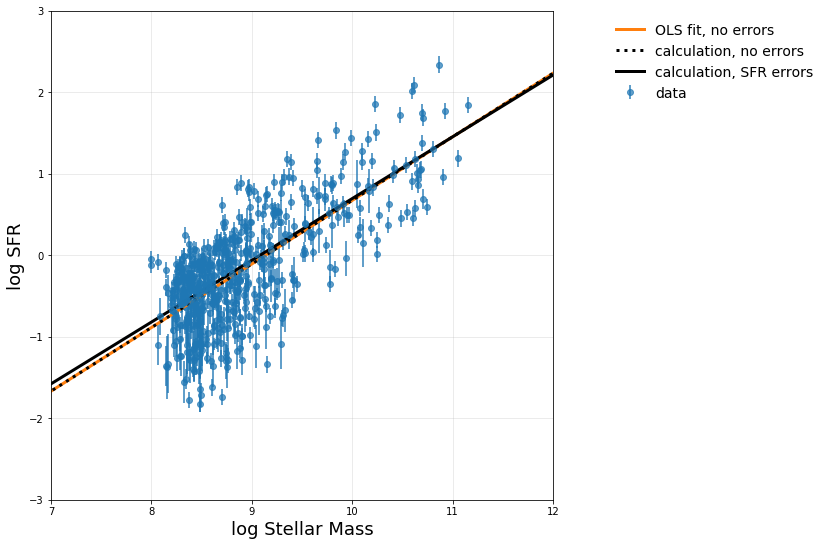

In [9]:
#---------------------------------------------------------------
# Case 4. Incorporating SFR measurement uncertainties
#---------------------------------------------------------------

Y = log_sfr[SFG_mask].reshape(-1,1)
A = np.ones((len(log_mstar[SFG_mask]),2))
A[0:,1] = log_mstar[SFG_mask] - 9

C = np.diag(np.ones_like(log_sfr[SFG_mask]))
Cinv = np.linalg.inv(C)

X_no_errs = np.dot(np.linalg.inv(np.dot(A.T,np.dot(Cinv,A))), np.dot(A.T,np.dot(Cinv,Y)))

sfr_errs = sfr_err[SFG_mask]
C = np.diag(sfr_errs)    
Cinv = np.linalg.inv(C)

X_sfr_errs = np.dot(np.linalg.inv(np.dot(A.T,np.dot(Cinv,A))), np.dot(A.T,np.dot(Cinv,Y)))


#-------------------------------------------------------------------------
# Compuate the Linear model result for comparison

x = log_mstar[SFG_mask].reshape(-1,1)-9
y = log_sfr[SFG_mask].reshape(-1,1)
mass_arr = np.arange(6,12.1).reshape(-1,1)
lr = linear_model.LinearRegression()
lr.fit(x, y)
line_y = lr.predict(mass_arr-9)


#----------------------------------------------------------------------------------------------------------------------
# Plot your results

plt.figure(figsize=(9,9))
plt.errorbar(log_mstar[SFG_mask].ravel(),log_sfr[SFG_mask].ravel(),yerr=sfr_errs,
             lw=0,elinewidth=2,marker='o',label='data',alpha=0.7)
plt.plot(mass_arr,line_y,'-',lw=3,label='OLS fit, no errors')
plt.plot(mass_arr,(mass_arr-9)*X_no_errs[1]+X_no_errs[0],'k:',lw=3,label='calculation, no errors')
plt.plot(mass_arr,(mass_arr-9)*X_sfr_errs[1]+X_sfr_errs[0],'k-',lw=3,label='calculation, SFR errors')
plt.xlabel('log Stellar Mass',fontsize=18)
plt.ylabel('log SFR',fontsize=18)
plt.axis([7,12,-3,3])
plt.legend(fontsize=14, edgecolor='w',loc=2,bbox_to_anchor=(1.1,1))
plt.grid(alpha=0.3)
plt.show()




-----------------------------------------------
Beta: [ 1.21992892  0.03706359]
Beta Std Error: [ 0.04341909  0.02446971]
Beta Covariance: [[  3.93619714e-04   3.78601666e-05]
 [  3.78601666e-05   1.25018165e-04]]
Residual Variance: 4.7894385600714875
Inverse Condition #: 0.6073410518711063
Reason(s) for Halting:
  Sum of squares convergence
-----------------------------------------------


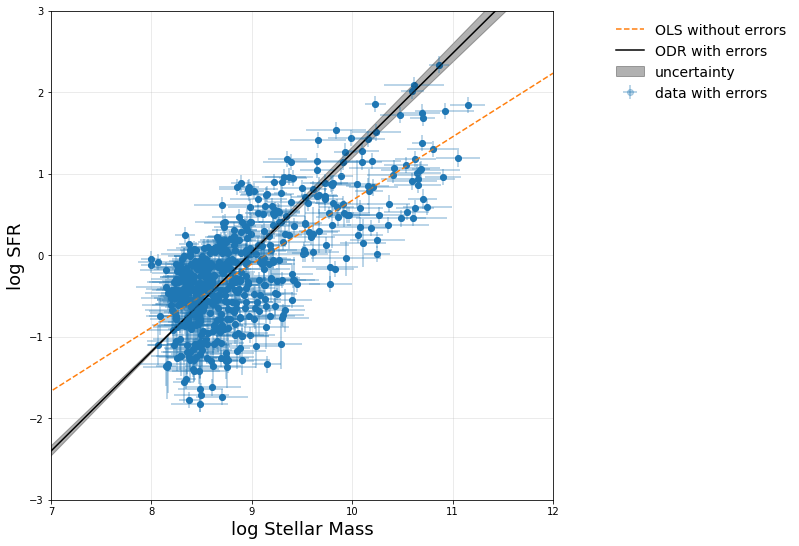

In [11]:
#---------------------------------------------------------------
# Case 5. Using Orthogonal Distance Regression 
#     - incorporating measurement uncertainties in both SFR and Stellar mass
#---------------------------------------------------------------
# link: https://docs.scipy.org/doc/scipy/reference/odr.html

def f(B,x):
    return B[0]*x + B[1]

linear = scipy.odr.Model(f)

sfr_mstar_data = scipy.odr.RealData(log_mstar[SFG_mask].ravel()-9,
                                    log_sfr[SFG_mask].ravel(), 
                                    sx = mass_err[SFG_mask],
                                    sy = sfr_err[SFG_mask])

odr_object = scipy.odr.ODR(sfr_mstar_data, linear, beta0=[1.,2.])

odr_fit = odr_object.run()

#----------------------------------------------------------------------------------------------------------------------
# Print the output from the fitting procedure.

print('-----------------------------------------------')
odr_fit.pprint()
print('-----------------------------------------------')

#----------------------------------------------------------------------------------------------------------------------
# Plot your results.

tx2 = (mass_arr-9)*(odr_fit.beta[0] +odr_fit.sd_beta[0]) + (odr_fit.beta[1] + odr_fit.sd_beta[1])
tx1 = (mass_arr-9)*(odr_fit.beta[0] -odr_fit.sd_beta[0]) + (odr_fit.beta[1] - odr_fit.sd_beta[1])

plt.figure(figsize=(9,9))
plt.errorbar(x.ravel()+9,y.ravel(),marker='o',
             xerr=mass_err[SFG_mask].ravel(),
             yerr=sfr_err[SFG_mask].ravel(),
            lw = 0, elinewidth=2, alpha=0.3, label='data with errors')
plt.scatter(log_mstar[SFG_mask].ravel(),log_sfr[SFG_mask].ravel())
plt.plot(mass_arr,line_y,'--',label='OLS without errors')
plt.plot(mass_arr, (mass_arr-9)*odr_fit.beta[0] + odr_fit.beta[1],'k-',label='ODR with errors')
plt.fill_between(mass_arr.ravel(), tx2.ravel(), tx1.ravel(),
                 alpha=0.3,color='k',label='uncertainty')
plt.xlabel('log Stellar Mass',fontsize=18)
plt.ylabel('log SFR',fontsize=18)
plt.axis([7,12,-3,3])
plt.legend(fontsize=14, edgecolor='w',loc=2,bbox_to_anchor=(1.1,1))
plt.grid(alpha=0.3)
plt.show()
